In [152]:
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import sys
caffe_root = '/Data/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
os.chdir(caffe_root)
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

modelpick = 2
# 0==SSD author's best model: SSD_512x512 
# 1==1073 img model
# 2==979 refined boundingbox model 

if modelpick == 0: 
    labelmap_file = '/Data/caffe/data/VOC0712/labelmap_voc.prototxt'
    model_def = '/Data/caffe/models/Volley/SSD512/deploy.prototxt'
    model_weights = '/Data/caffe/models/Volley/SSD512/VGG_coco_SSD_512x512.caffemodel'
    image_resize = 512
    model_str = "SSD512"
elif modelpick == 1:
    labelmap_file = '/Data/caffe/data/Volley/labelmap_volley.prototxt'
    model_def = '/Data/caffe/models/Volley/1073img-model/SSD_300x300/deploy.prototxt'
    model_weights = '/Data/caffe/models/Volley/1073img-model/SSD_300x300/VGG_Volley_SSD_300x300_iter_60000.caffemodel'
    image_resize = 300        
    model_str = "1073img"
else:
    labelmap_file = '/Data/caffe/data/Volley/labelmap_volley.prototxt'
    model_def = '/Data/caffe/models/Volley/Feb20/deploy.prototxt'
    model_weights = '/Data/caffe/models/Volley/Feb20/VGG_Volley_SSD_300x300_iter_80000.caffemodel'
    image_resize = 300
    model_str = "979new"


print caffe_root

/Data/caffe/


In [153]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

In [154]:

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

300


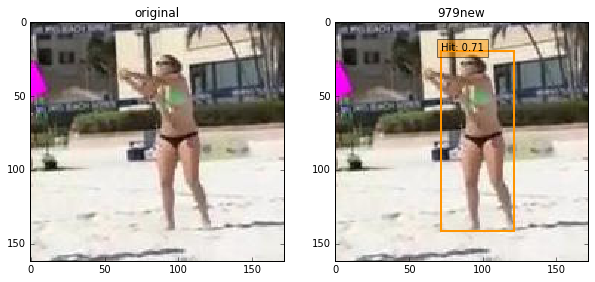

In [169]:
# set net to batch size of 1
net.blobs['data'].reshape(1,3,image_resize,image_resize)
print image_resize
imgname = "001055"
#image = caffe.io.load_image('/Data/caffe/data/Volley/Images/'+imgname+".jpg")
image = caffe.io.load_image('/Data/caffe/data/Volley/bugs/'+imgname+".jpg")

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("original")

transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
detections = net.forward()['detection_out']

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title(model_str)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})


In [94]:
# for each layer, show the output shape
# here 50 is the batch size 
# Solution
# Conv4_3: 38 * 38 * 4 = 5776
# Conv7: 19 * 19 * 6 = 2166
# Conv8_2: 10 * 10 * 6 = 600
# Conv9_2: 5 * 5 * 6 = 150
# Conv10_2: 3 * 3 * 4 = 36
# Conv11_2: 4
# Total: 5776+ 2166 + 600 + 150 + 36 + 4 = 8732
# for each prior box, there are 4 coordinates => 5776*4 = 23104 (conv4_3_norm_mbox_priorbox	(1, 2, 23104))
# conv7: 2166*4= 8664 => fc7_mbox_priorbox	(1, 2, 8664), and so on ... 
# 5776 box for smallest obj detection while last 4 is for the whole image detection 
    
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 300, 300)
data_input_0_split_0	(1, 3, 300, 300)
data_input_0_split_1	(1, 3, 300, 300)
data_input_0_split_2	(1, 3, 300, 300)
data_input_0_split_3	(1, 3, 300, 300)
data_input_0_split_4	(1, 3, 300, 300)
data_input_0_split_5	(1, 3, 300, 300)
data_input_0_split_6	(1, 3, 300, 300)
conv1_1	(1, 64, 300, 300)
conv1_2	(1, 64, 300, 300)
pool1	(1, 64, 150, 150)
conv2_1	(1, 128, 150, 150)
conv2_2	(1, 128, 150, 150)
pool2	(1, 128, 75, 75)
conv3_1	(1, 256, 75, 75)
conv3_2	(1, 256, 75, 75)
conv3_3	(1, 256, 75, 75)
pool3	(1, 256, 38, 38)
conv4_1	(1, 512, 38, 38)
conv4_2	(1, 512, 38, 38)
conv4_3	(1, 512, 38, 38)
conv4_3_relu4_3_0_split_0	(1, 512, 38, 38)
conv4_3_relu4_3_0_split_1	(1, 512, 38, 38)
pool4	(1, 512, 19, 19)
conv5_1	(1, 512, 19, 19)
conv5_2	(1, 512, 19, 19)
conv5_3	(1, 512, 19, 19)
pool5	(1, 512, 19, 19)
fc6	(1, 1024, 19, 19)
fc7	(1, 1024, 19, 19)
fc7_relu7_0_split_0	(1, 1024, 19, 19)
fc7_relu7_0_split_1	(1, 1024, 19, 19)
fc7_relu7_0_split_2	(1, 1024, 19, 19)
fc7_relu7_0_split_3	(

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

import numpy as np
import os
import pdb

caffe_root = '/Data/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import time

import caffe
from caffe.proto import caffe_pb2

caffe.set_device(0)
caffe.set_mode_gpu()
# caffe.set_mode_cpu()
# We create a solver that fine-tunes from a previously trained network.
#solver = caffe.SGDSolver(caffe_root + 'models/Volley/1073img-model/SSD_300x300/solver.prototxt')
#solver = caffe.SGDSolver('/Data/caffe/models/Volley/SSD512/deploy.prototxt')
solver = caffe.SGDSolver('/Data/caffe/models/Volley/SSD_300x300/solver.prototxt')

#solver.net.copy_from(caffe_root + 'models/Volley/VGG_ILSVRC_16_layers_fc_reduced.caffemodel')
solver.net.copy_from('/Data/caffe/models/Volley/1073img-model/SSD_300x300/VGG_Volley_SSD_300x300_iter_60000.caffemodel')
#solver.net.copy_from('/Data/caffe/models/Volley/SSD512/VGG_coco_SSD_512x512.caffemodel')
#solver.net.copy_from('/Data/caffe/models/Volley/SSD_300x300/VGG_Volley_SSD_300x300_iter_6000.caffemodel')

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

net = solver.net

print caffe_root


/Data/caffe/


In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = '/Data/caffe/data/Volley/labelmap_volley.prototxt'
#labelmap_file = '/Data/caffe/data/VOC0712/labelmap_voc.prototxt'

file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    #print num_labels
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

In [3]:
# Forward one step.
solver.step(1)

300 300


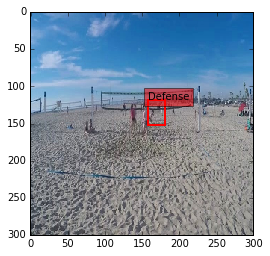

In [15]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

img_blob = net.blobs['data'].data
img_height = img_blob.shape[2]
img_width = img_blob.shape[3]
print img_height, img_width
label_blob = net.blobs['label'].data[0,0,:,:]
num_labels = label_blob.shape[0]

i = 11

img = transformer.deprocess('data', img_blob[i])
plt.imshow(img)
currentAxis = plt.gca()
for j in xrange(num_labels):
    gt_bbox = label_blob[j, :]    
    if gt_bbox[0] == i:
            xmin = gt_bbox[3] * img_width
            ymin = gt_bbox[4] * img_height
            xmax = gt_bbox[5] * img_width
            ymax = gt_bbox[6] * img_height
            gt_label = int(gt_bbox[1])
            coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
            color = colors[gt_label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            label = get_labelname(labelmap, gt_bbox[1])[0]
            currentAxis.text(xmin, ymin, label, bbox={'facecolor':color, 'alpha':0.5})
            


In [16]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)


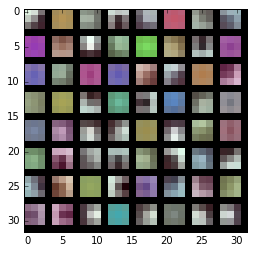

In [17]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

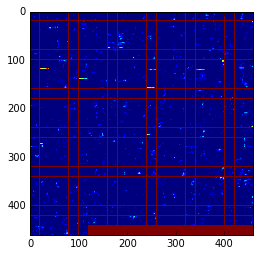

In [18]:
feat = net.blobs['conv5_3'].data[0, :]
vis_square(feat, padval=1)

In [19]:
fc7_mbox_loc = net.blobs['fc7_mbox_loc'].data
print fc7_mbox_loc[0,:,1,2]

fc7_mbox_loc_perm = net.blobs['fc7_mbox_loc_perm'].data
print fc7_mbox_loc_perm[0,1,2,:]

[ 0.25573176  1.3776906  -1.7627624   1.6390353   0.0289936   1.6917526
 -2.056817    1.1267561   0.33958077  1.4575311  -1.7043415   1.5351616
  0.3789276   1.8785713  -0.84863245  0.7121196   0.15878044  0.7372459
 -1.8770728   0.8839538   0.43841732  2.040688   -0.31453797  0.03604335]
[ 0.25573176  1.3776906  -1.7627624   1.6390353   0.0289936   1.6917526
 -2.056817    1.1267561   0.33958077  1.4575311  -1.7043415   1.5351616
  0.3789276   1.8785713  -0.84863245  0.7121196   0.15878044  0.7372459
 -1.8770728   0.8839538   0.43841732  2.040688   -0.31453797  0.03604335]


(32, 3, 300, 300)
(34928,)
[-0.03666667 -0.03666667  0.06333333 ... -0.12225398  0.811127
  1.122254  ]
109.00000333786011 28.999999165534973 139.00000154972076 59.00000184774399
102.7868002653122 22.78679609298706 145.21320462226868 65.2132049202919
102.7868002653122 33.39339718222618 145.21320462226868 54.6066015958786
113.39339911937714 22.78679609298706 134.60660576820374 65.2132049202919


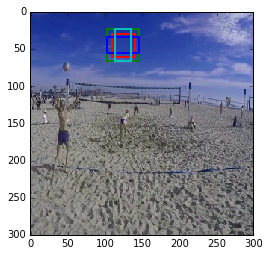

In [65]:
img_blob = net.blobs['data'].data
print img_blob.shape
img_height = img_blob.shape[2]
img_width = img_blob.shape[3]

priorbox = net.blobs['mbox_priorbox'].data[0,0,:]
print net.blobs['mbox_priorbox'].data[0,0,:].shape
num_priors = priorbox.shape[0]
print priorbox
colors='rgbcmy'

i=1

img = transformer.deprocess('data', img_blob[i])
plt.imshow(img)
currentAxis = plt.gca()
for j in xrange(820,824):
    prior_bbox = priorbox[j*4:(j+1)*4]
    #print prior_bbox
    xmin = prior_bbox[0] * img_width
    ymin = prior_bbox[1] * img_height
    xmax = prior_bbox[2] * img_width
    ymax = prior_bbox[3] * img_height
    print xmin,ymin,xmax,ymax
    coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[j%4], linewidth=2))